In [36]:
import os
import time
import json
import keras
import numpy as np
import pandas as pd
import seaborn as sb
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from keras.optimizers import Adam
from keras.utils import plot_model
from matplotlib.image import imread
from keras.preprocessing import image
from keras.models import Sequential, load_model
from keras.losses import CategoricalCrossentropy
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB3, EfficientNetB4, EfficientNetB7
from keras.layers import GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization

# Dados
## Explorando dados

In [3]:
# Importando csv do dataset
data = pd.read_csv('dados/train.csv', sep = ',')

In [4]:
data.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [5]:
# Lendo json e crinado mapping para para classe
with open('dados/label_num_to_disease_map.json') as f:
    mapping = json.loads(f.read())
    mapping = {int(k): v for k, v in mapping.items()}

mapping

{0: 'Cassava Bacterial Blight (CBB)',
 1: 'Cassava Brown Streak Disease (CBSD)',
 2: 'Cassava Green Mottle (CGM)',
 3: 'Cassava Mosaic Disease (CMD)',
 4: 'Healthy'}

In [6]:
# Adicionando label_name ao conjunto de dados, e ondenando colunas
data['label_name'] = data['label'].map(mapping)
data = data[['image_id', 'label_name', 'label']]

In [7]:
data.head()

,image_id,label_name,label
0,1000015157.jpg,Cassava Bacterial Blight (CBB),0
1,1000201771.jpg,Cassava Mosaic Disease (CMD),3
2,100042118.jpg,Cassava Brown Streak Disease (CBSD),1
3,1000723321.jpg,Cassava Brown Streak Disease (CBSD),1
4,1000812911.jpg,Cassava Mosaic Disease (CMD),3


In [8]:
# Verificando frequencia
data.label_name.value_counts()

Cassava Mosaic Disease (CMD)           13158
Healthy                                 2577
Cassava Green Mottle (CGM)              2386
Cassava Brown Streak Disease (CBSD)     2189
Cassava Bacterial Blight (CBB)          1087
Name: label_name, dtype: int64

In [9]:
# Verificando proporção 
data.label_name.value_counts(normalize = True) * 100

Cassava Mosaic Disease (CMD)           61.494602
Healthy                                12.043744
Cassava Green Mottle (CGM)             11.151096
Cassava Brown Streak Disease (CBSD)    10.230406
Cassava Bacterial Blight (CBB)          5.080151
Name: label_name, dtype: float64

# Preparando os dados
## HoldOut
Separando dados de treino e teste

In [33]:
# Definindo paths de treino e teste
train_path = 'dados/train_images/'
test_path = 'dados/test_images/'
imagem_teste = 'dados/test_images/2216849948.jpg'

In [11]:
# Criando amostra para treino e teste estrafiticada
train, test = train_test_split(data, test_size = 0.10, shuffle = True, random_state = 0, stratify = data['label_name'])

In [12]:
# Verificando frequencia do conjunto de trian
train.label_name.value_counts()

Cassava Mosaic Disease (CMD)           11842
Healthy                                 2319
Cassava Green Mottle (CGM)              2148
Cassava Brown Streak Disease (CBSD)     1970
Cassava Bacterial Blight (CBB)           978
Name: label_name, dtype: int64

In [13]:
# Verificando frequencia do conjunto de test
test.label_name.value_counts()

Cassava Mosaic Disease (CMD)           1316
Healthy                                 258
Cassava Green Mottle (CGM)              238
Cassava Brown Streak Disease (CBSD)     219
Cassava Bacterial Blight (CBB)          109
Name: label_name, dtype: int64

## Tratamento das imagens
Nossas imagens não estão no formato adequado para usarmos em uma rede neural, usaremos a classe **ImageDataGenerator** com o method **flow_from_dataframe** do keras. Ele irar percorrer nosso cvs e diretório de dados, carregando os dados de imagem e retornar a entrada (matrizes de pixels) e a saída (número inteiro de classe).

### Definindo parâmetros para tratamnetos das imagens

In [14]:
train_generator = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    vertical_flip = True,
    fill_mode = 'nearest',
    #rescale = 1/225
)

test_generator = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input
)

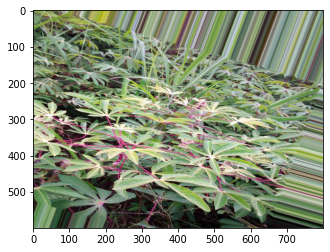

In [34]:
imagem_teste = imread(imagem_teste)
plt.imshow(image_gen.random_transform(imagem_teste))

In [15]:
train_set = train_generator.flow_from_dataframe(
    dataframe = train,
    directory = train_path,
    seed = 42,
    x_col = 'image_id',
    y_col = 'label_name',
    target_size = (456, 456),
    class_mode = 'categorical',
    interpolation = 'nearest',
    shuffle = True,
    batch_size = 15
)

test_set = test_generator.flow_from_dataframe(
    dataframe = test,
    directory= train_path,
    seed = 42,
    x_col = 'image_id',
    y_col = 'label_name',
    target_size = (456, 456),
    class_mode = 'categorical',
    interpolation = 'nearest',
    shuffle = True,
    batch_size = 15
)

Found 19257 validated image filenames belonging to 5 classes.
Found 2140 validated image filenames belonging to 5 classes.


# Modelos
### Trabalhando hiperparâmetros da rede neural

In [16]:
# Definindo parâmetros para treino e teste
STEP_SIZE_TRAIN = train_set.n // train_set.batch_size
STEP_SIZE_TEST = test_set.n // test_set.batch_size

# Definindo loss function
loss = CategoricalCrossentropy(from_logits = False, label_smoothing = 0.0001, name = 'categorical_crossentropy')
# Pare de treinar quando o val_loss parar de diminuir por 3 épocas
es = EarlyStopping(monitor = 'val_loss', patience = 3, verbose = 1, mode = 'min', restore_best_weights = True)
# Salve o modelo com o mínimo de perda de validação
checkpoint = ModelCheckpoint("CassavaLeafDisease.h5", monitor = 'val_loss', save_best_only = True, mode = 'min')
# Reduza a taxa de aprendizagem quando a aprendizagem estagnar
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 2, min_lr = 1e-6, mode = 'min', verbose = 1)

## EfficientNetB3

In [17]:
# Criando modelo de rede neural
modelo = Sequential()
modelo.add(EfficientNetB3(input_shape = (456, 456, 3), include_top = False, weights = 'imagenet', drop_connect_rate = 0.6))
modelo.add(GlobalAveragePooling2D())
modelo.add(Flatten())
modelo.add(Dense(256, activation = 'relu', bias_regularizer = tf.keras.regularizers.L1L2(l1 = 0.01, l2 = 0.001)))
modelo.add(Dropout(0.5))
modelo.add(Dense(5, activation = 'softmax'))

In [ ]:
# Bloqueando pesos
for layer in modelo.layers:
    layer.trainable = False

# Compilando rede neural
modelo.compile(optimizer = Adam(lr = 0.001, decay = 0.0001, clipvalue = 0.5), loss = loss, metrics = ['categorical_accuracy'])

In [ ]:
# Informações de parâmetros do modelo 
modelo.summary()

In [ ]:
# Plotando fluxograma do modelo
plot_model(modelo, to_file = 'img/modelo.png',  show_shapes = True)

In [ ]:
inicio = time.time()

# Treinamento e teste do modelo
results = modelo.fit(
        train_set, 
        validation_data = test_set, 
        epochs = 15, 
        batch_size = 15, 
        steps_per_epoch = STEP_SIZE_TRAIN,
        validation_steps = STEP_SIZE_TEST, 
        callbacks = [es, checkpoint, reduce_lr]
)

print()
fim = time.time()
print(fim - inicio)

# Salvando modelo
# modelo.save('CassavaLeafDisease')

# Submission

In [ ]:
# Carregando modelo
leaf_model = load_model('CassavaLeafDisease.h5')

In [ ]:
# Realizando predição com imagem teste 
TEST_DIR = 'dados/test_images/'
test_images = os.listdir(TEST_DIR)
predictions = []

for image in test_images:
    img = Image.open(TEST_DIR + image)
    img = img.resize((456, 456), resample = Image.NEAREST) 
    img = np.expand_dims(img, axis = 0)
    # Realizando a predição, argmax retorna o indice da maior probabilidade da lista
    predictions.extend(leaf_model.predict(img).argmax(axis = 1))

In [ ]:
# Realizando predição com imagem teste 
TEST_DIR = 'dados/test_images/'
test_images = os.listdir(TEST_DIR)
predictions = []

for image in test_images:
    teste4 = image.load_img(TEST_DIR + image, target_size = (456, 456))
    teste4 = np.expand_dims(teste4, axis = 0)
    # Realizando a predição, argmax retorna o indice da maior probabilidade da lista
    predictions.extend(leaf_model.predict(teste4).argmax(axis = 1))
    predictions

In [ ]:
# Gerando arquivo submission.csv
submission = pd.DataFrame({'image_id': test_images, 'label': predictions})
submission.to_csv('submission.csv', index = False)
display(submission)